<a href="https://colab.research.google.com/github/hareidx/FASTAI_HAREID/blob/main/FASTAI_Week_01_My_Own_Take_Version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FAST AI Week 01 - My Own Take

In [2]:
!pip install -Uqq fastai

     |████████████████████████████████| 197 kB 4.9 MB/s 
     |████████████████████████████████| 60 kB 7.6 MB/s 


In [3]:
# begin imports

from fastcore.all import *
from fastdownload import download_url
import time

In [4]:
# create function for searching for and locating images from Duck Duck Go
def search_images(term, max_images=300) -> "L(urls)[:max_images]":
  url = 'https://duckduckgo.com/'
  res = urlread(url,data={'q':term})
  searchObj = re.search(r'vqd=([\d-]+)\&', res)
  requestUrl = url + 'i.js'
  params = dict(l='us=en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
  urls,data = set(), {'next':1}
  while len(urls)<max_images and 'next' in data:
    data = urljson(requestUrl, data=params)
    urls.update(L(data['results']).itemgot('image'))
    requestUrl = url + data['next']
    time.sleep(0.2)
  return L(urls)[:max_images]

In [5]:
urls = search_images('elephant photos', max_images=1)
urls[0]

'https://www.zsl.org/sites/default/files/media/2014-10/SG9A8359.jpg'

In [6]:

dest = 'elephant.jpg'
download_url(urls[0], dest, show_progress=False)

Path('elephant.jpg')

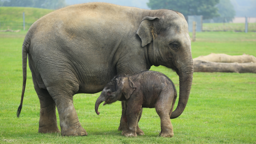

In [7]:
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

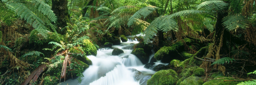

In [8]:
search_term = 'jungle photos'
image_save = 'jungle.jpg'
download_url(search_images(search_term, max_images=1)[0],image_save, show_progress=False)
Image.open(image_save).to_thumb(256,256)

In [9]:
# Download a set of images of birds and forests for training a model
searches = 'jungle', 'elephant'
path = Path('bird_or_not')

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} photo'))
  resize_images(path/o, max_size=400, dest=path/o)

# Train model

In [10]:
# remove failed downloads

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f'There were {len(failed)} failed images')

There were 4 failed images


In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

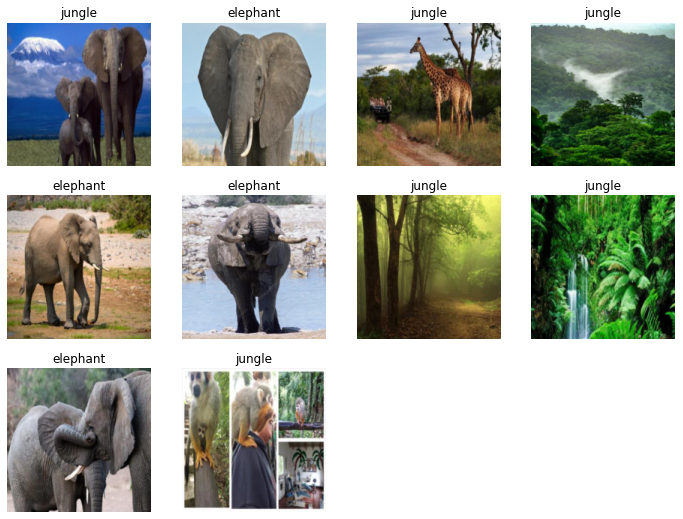

In [12]:
dls.show_batch(max_n=10)

Here what each of the DataBlock parameters means:  
_blocks=(ImageBlock, CategoryBlock),_  
The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").  
  
_get_items=get_image_files,_  
To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).  
  
_splitter=RandomSplitter(valid_pct=0.2, seed=42),_  
Split the data into training and validation sets randomly, using 20% of the data for the validation set.  
  
  _get_y=parent_label,_  
  The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).  
  
_item_tfms=[Resize(192, method='squish')]_  
Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).  


## Now we're ready to train our model. The fastest widely used computer vision model is resnet18.

fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [14]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.779435,0.853913,0.128205,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.189620,0.418121,0.076923,01:36
1,0.128051,0.308740,0.042735,01:35
2,0.093334,0.297379,0.051282,01:36
3,0.073919,0.291061,0.059829,01:35


In [15]:
is_elephant,_,probs = learn.predict(PILImage.create('elephant.jpg'))
print(f'This is a" {is_elephant}.')
print(f'Probability it is a elephant: {probs[0]:.4f}')

This is a" elephant.
Probability it is a elephant: 1.0000
